## GDP and Health expenditure
Richer countries can afford to invest more on healthcare, on work and road safety, and other measures that reduce mortality. On the other hand, richer countries may have less health expenditures. Is there any relation between the wealth of a country and the health expenditure of its inhabitants?

The following analysis checks whether there is any correlation between the total gross domestic product (GDP) of a country in 2018 and the health expenditure of people in that country in 2018.

## Getting the data
Two datasets of the World Bank are considered. One dataset, available at https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD, lists the GDP of the world's countries in current US dollars, for various years. The use of a common currency allows us to compare GDP values across countries. The other dataset, available at https://data.worldbank.org/indicator/SH.XPD.CHEX.GD.ZS, lists the life expectancy of the world's countries. The datasets were downloaded as CSV files in 2018.

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import pandas as pd

YEAR = 2018
GDP_INDICATOR = 'NY.GDP.PCAP.PP.CD'
gdpReset = pd.read_csv('WB GDP 2018.csv')

HEALTH_INDICATOR = 'SH.XPD.CHEX.GD.ZS'
healthReset = pd.read_csv('WB HE 2018.csv')
healthReset.head()

,country,year,SH.XPD.CHEX.GD.ZS
0,Arab World,2018,5.225987
1,Caribbean small states,2018,6.363417
2,Central Europe and the Baltics,2018,6.610860
3,Early-demographic dividend,2018,5.042913
4,East Asia & Pacific,2018,6.669777


## Cleaning the data
Inspecting the data with head() and tail() shows that:

* the first 47 rows are aggregated data, for the Arab World, the Caribbean small states, and other country groups used by the World Bank;
* GDP and life expectancy values are missing for some countries.

The data is therefore cleaned by:

* removing the first 47 rows;
* removing rows with unavailable values.

In [2]:
gdpCountries = gdpReset[47:].dropna()
healthCountries = healthReset[47:].dropna()

## Transforming the data
The World Bank reports GDP in US dollars and cents. To make the data easier to read, the GDP is converted to millions of British pounds (the author's local currency) with the following auxiliary functions, using the average 2018 dollar-to-pound conversion rate provided by http://www.ukforex.co.uk/forex-tools/historical-rate-tools/yearly-average-rates.

###### GBP to USD 2018 is 1.334801¶

In [3]:
def roundCurrency (value):
    value = float(value)
    return round(value)

def usdToGBP (usd):
    usd = float(usd)
    convert_usd = usd/1.334801
    return convert_usd

GDP = 'GDP (£)'
gdpCountries[GDP] = gdpCountries[GDP_INDICATOR].apply(usdToGBP).apply(roundCurrency)
gdpCountries.head()

,country,year,NY.GDP.PCAP.PP.CD,GDP (£)
47,Afghanistan,2018,2083.321897,1561
48,Albania,2018,13546.473790,10149
49,Algeria,2018,11925.798560,8935
52,Angola,2018,7102.405887,5321
53,Antigua and Barbuda,2018,21630.179510,16205


The unnecessary columns can be dropped.

In [4]:
COUNTRY = 'country'
headings = [COUNTRY, GDP]
gdpClean = gdpCountries[headings]
gdpClean.head()

,country,GDP (£)
47,Afghanistan,1561
48,Albania,10149
49,Algeria,8935
52,Angola,5321
53,Antigua and Barbuda,16205


The World Bank reports the Health Expenditure with several decimal places. After rounding, the original column is discarded.

In [5]:
HEALTH = 'Health_exp (Facilities)'
healthCountries[HEALTH] = healthCountries[HEALTH_INDICATOR].apply(round)
headings = [COUNTRY, HEALTH]
healthClean = healthCountries[headings]
healthClean.head()

,country,Health_exp (Facilities)
47,Afghanistan,9
48,Albania,5
49,Algeria,6
51,Andorra,7
52,Angola,3


## Combining the data
The tables are combined through an inner join on the common 'country' column.

In [6]:
gdpVsHealth = pd.merge(gdpClean, healthClean, on=COUNTRY, how='inner')
gdpVsHealth.head()

,country,GDP (£),Health_exp (Facilities)
0,Afghanistan,1561,9
1,Albania,10149,5
2,Algeria,8935,6
3,Angola,5321,3
4,Antigua and Barbuda,16205,5


## Calculating the correlation
To measure if the life expectancy and the GDP grow together, the Spearman rank correlation coefficient is used. It is a number from -1 (perfect inverse rank correlation: if one indicator increases, the other decreases) to 1 (perfect direct rank correlation: if one indicator increases, so does the other), with 0 meaning there is no rank correlation. A perfect correlation doesn't imply any cause-effect relation between the two indicators. A p-value below 0.05 means the correlation is statistically significant.

In [7]:
from scipy.stats import spearmanr

gdpColumn = gdpVsHealth[GDP]
healthColumn = gdpVsHealth[HEALTH]
(correlation, pValue) = spearmanr(gdpColumn, healthColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.2606301506061772
It is statistically significant.


The value shows a direct correlation, i.e. richer countries tend to have longer life expectancy, but it is not very strong.

## Showing the data
Measures of correlation can be misleading, so it is best to see the overall picture with a scatterplot. The GDP axis uses a logarithmic scale to better display the vast range of GDP values.

<AxesSubplot:xlabel='GDP (£)', ylabel='Health_exp (Facilities)'>

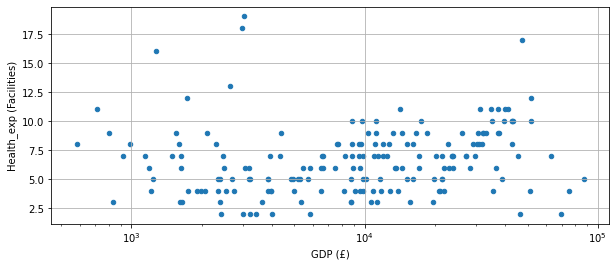

In [8]:
%matplotlib inline
gdpVsHealth.plot(x=GDP, y=HEALTH, kind='scatter', grid=True, logx=True, figsize=(10, 4))

The plot shows there is no clear correlation: there are rich countries with low health expenditure, poor countries with a little more expenditure than the rich countries, and countries with around 10 thousand (10^4) pounds GDP have almost the full range of values, from below 2.5 to over 10 facilities. Towards the lower and higher end of GDP, the variation remains the same. Above 40 thousand pounds of GDP (2nd tick mark to the right of 10^4), most countries have an health expenditure of 10 facilities or less, whilst below that threshold most countries' health expenditure is below 10 facilities.

Comparing the 10 poorest countries and the 10 countries with the lowest health expenditure shows that total GDP is a rather crude measure. The population size should be taken into account for a more precise definiton of what 'poor' and 'rich' means. Furthermore, looking at the countries below, droughts and internal conflicts may also play a role in health expenditure.

In [9]:
# the 10 countries with lowest GDP
gdpVsHealth.sort_values(GDP).head(10)

,country,GDP (£),Health_exp (Facilities)
26,Burundi,584,8
31,Central African Republic,716,11
97,Malawi,800,9
37,"Congo, Dem. Rep.",833,3
119,Niger,922,7
111,Mozambique,990,8
93,Liberia,1149,7
163,Togo,1192,6
32,Chad,1210,4
96,Madagascar,1238,5


In [10]:
# the 10 countries with lowest health expenditure
gdpVsHealth.sort_values(HEALTH).head(10)

,country,GDP (£),Health_exp (Facilities)
23,Brunei Darussalam,46344,2
45,Djibouti,4001,2
133,Qatar,69813,2
38,"Congo, Rep.",2998,2
17,Benin,2426,2
89,Lao PDR,5827,2
12,Bangladesh,3408,2
127,Papua New Guinea,3218,2
54,Ethiopia,1614,3
124,Pakistan,3637,3


## Conclusions
To sum up, there is no strong correlation between a country's wealth and the health expenditure of its inhabitants: there is often a wide variation of health expenditure for countries with similar GDP, countries with the lowest health expenditure are not the poorest countries, and countries with the highest expenditure are not the richest countries. Nevertheless there is some relationship, because the vast majority of countries with a health expenditure below 10 facilities is on the left half of the scatterplot.